In [33]:
import numpy as np

import rasterio
import fiona

from scripts.utils import trees_detection

import matplotlib.pyplot as plt

In [14]:
%matplotlib notebook

In [40]:
CROP_SIZE = 20

In [3]:
LAYER_PATH = '/Users/vasilii.mosin/Desktop/ForestHype/data/pp_2/pp_2_hsi_clipped.tif'

In [4]:
dataset = rasterio.open(LAYER_PATH)

In [5]:
raster = dataset.read()

In [6]:
trees_detection(dataset, raster[0], '/Users/vasilii.mosin/Desktop/detected_trees', 
                smoothing=1.0, min_distance=10, exclude_border=CROP_SIZE)

In [7]:
detected_trees = fiona.open('/Users/vasilii.mosin/Desktop/detected_trees', 'r')

In [16]:
print(len(detected_trees))

2760


In [41]:
tree_images = []

for detected_tree in detected_trees:
    tree_top = dataset.index(*detected_tree['geometry']['coordinates'])
    tree_image = raster[:,tree_top[0]-CROP_SIZE:tree_top[0]+CROP_SIZE,
                        tree_top[1]-CROP_SIZE:tree_top[1]+CROP_SIZE]
    if not np.any(tree_image==0):
        tree_images.append(tree_image)

<IPython.core.display.Javascript object>


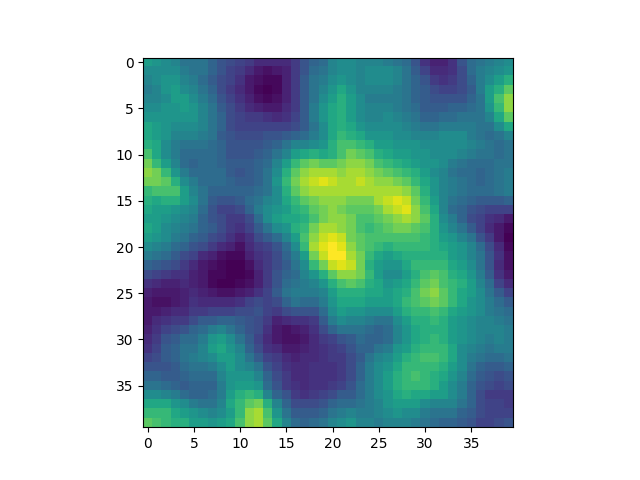

In [45]:
plt.imshow(tree_images[4][0])
plt.show()